Below is a summary of what your code is doing and a detailed table that explains how the behavior changes with different settings for the two key flags: **TRAIN_METHOD** and **RETURN_LOG_DENSITY**.

---

## Overview of Your Code

1. **Data & Feature Extraction:**
   - **Dataset Loading:**  
     You load the MASS dataset (with a maximum of 2 images per split for debugging) using your custom dataloader.
   - **Pretrained ResNet:**  
     You extract features from images with a pretrained ResNet50 (cut off after the last convolutional layers and pooled to a 2048-dimensional vector). These features serve as the input to your subsequent log-density network.
   - **Noise Injection:**  
     You generate a set of noise levels (using a geometric progression between SIGMA_MIN and SIGMA_MAX). For each batch, you “repeat” the extracted features for every noise level and add scaled Gaussian noise. Then, you concatenate the noise level as an extra feature (so the network knows at which noise level it is operating).

2. **Model and Loss Setup:**
   - **Model:**  
     You define an MLP (via the MULDE library’s `MLPs`) that takes as input the 2048-dim ResNet features plus one extra dimension (the noise level) and outputs a log-density prediction per pixel (reshaped to a WINDOW_SIZE × WINDOW_SIZE image).
   - **Loss Branches:**
     - **DSM (Denoising Score Matching) Loss:**  
       For all samples with **nonzero noise** (σ ≠ 0), you compute a DSM loss. This involves comparing the network’s score prediction (the gradient of the log-density) with the scaled noise that was added.
     - **Segmentation Loss:**  
       For the “clean” branch (where noise level is 0), if available, you convert the log-density output (after applying a sigmoid) into segmentation predictions and compute a combined segmentation loss (a weighted sum of MSE, Binary Cross-Entropy, and Dice losses).  
   - **Training Modes:**  
     The overall loss is defined by the variable **TRAIN_METHOD**:
     - In **"Unsupervised"** mode, only the DSM loss is used.
     - In **"Hybrid"** mode, both segmentation loss and a weighted DSM loss are combined.
     - Otherwise, the code defaults to using only the segmentation loss.

3. **Gradient Handling in Validation:**
   - In the validation loop, you wrap the overall loop in `torch.no_grad()` to disable gradient tracking. However, because the DSM loss computation requires computing gradients (via `torch.autograd.grad` inside your model’s `score()` method), you temporarily enable gradients with `torch.enable_grad()` in the DSM branch.  
   - **Note:**  
     While this is necessary for computing the DSM loss (which is based on gradients with respect to the input), it is somewhat unusual to compute gradients during validation. This is acceptable if you only need the loss values for evaluation and are not using them to update model weights—but it could be less efficient.

4. **Live Plotting & Checkpointing:**
   - A live plotting class updates training and validation plots in Jupyter.
   - Checkpoints are saved whenever the validation loss improves, using helper functions for saving and loading the model and optimizer state.

---

## Detailed Table: Effects of TRAIN_METHOD and RETURN_LOG_DENSITY

The behavior of your loss calculations and metric computations depends on two flags:

- **TRAIN_METHOD:** Controls which branch of loss is used.
- **RETURN_LOG_DENSITY:** Determines whether your model returns both the score and log-density (needed for segmentation loss).

| **Configuration** | **TRAIN_METHOD** | **RETURN_LOG_DENSITY** | **DSM Loss Calculation** | **Segmentation Branch & Loss** | **Total Loss Computed** | **Metrics Computed** |
|-------------------|------------------|------------------------|----------------------------|--------------------------------|-------------------------|----------------------|
| **Case 1**        | Unsupervised     | True                   | Computed for all samples with σ ≠ 0 (using autograd for score) | *Not used:* Although log-density is returned, the segmentation branch is ignored in the loss calculation | **Loss = DSM loss** | Only DSM loss is used for training; segmentation metrics are not computed |
| **Case 2**        | Unsupervised     | False                  | Computed as in Case 1 (model returns only score output) | *Not used:* No log-density is returned, so segmentation branch is not available | **Loss = DSM loss** | Only DSM loss is used; segmentation metrics are not computed |
| **Case 3**        | Hybrid           | True                   | Computed for all samples with σ ≠ 0 | For clean samples (σ = 0): log-density is used to compute segmentation predictions (via sigmoid) and segmentation loss is calculated | **Loss = segmentation loss + DSM_WEIGHT × DSM loss** | Both DSM loss (affecting training) and segmentation metrics (precision, recall, F1, IoU) are computed |
| **Case 4**        | Hybrid           | False                  | Computed as in Case 1 (DSM loss is computed) | *Not computed:* Since log-density is not returned, segmentation loss is zero | **Loss = DSM_WEIGHT × DSM loss** (i.e. effectively DSM loss only) | Segmentation metrics will not be available (or remain at default) since the segmentation branch is inactive |
| **Case 5 (Default / Other)** | *Any other mode* (e.g., segmentation-only) | True/False | DSM loss is computed but may be ignored if only segmentation branch is used | If TRAIN_METHOD does not match "Unsupervised" or "Hybrid", the code falls back to using segmentation loss only (provided log-density is returned) | **Loss = segmentation loss** (if log-density is available) or 0 if not | Segmentation metrics computed if segmentation branch is active |

---

## Loss Calculations and Metric Details

- **DSM Loss Calculation:**
  - For samples with nonzero noise (σ ≠ 0), you compute:
    - **Score Prediction:**  
      Obtained via `score_pred = log_density_model.score(features_with_noise, ...)`.
    - **Target Comparison:**  
      Compare `score_pred[:, :-1]` (all but the last column, which is the noise level) to the scaled noise (`noise_added / (σ²)`).
    - **Loss Term:**  
      You compute the norm of the difference for each sample, weight it by σ² (lambda factor), and then average (normalized by batch size).
  
- **Segmentation Loss Calculation:**
  - Only computed on the “clean” branch (σ == 0). If log-density is returned (i.e., RETURN_LOG_DENSITY is True):
    - **Log-Density to Segmentation:**  
      The log-density output is reshaped to (B, WINDOW_SIZE, WINDOW_SIZE) and passed through a sigmoid to produce segmentation probabilities.
    - **Combined Loss:**  
      The segmentation loss is a weighted sum of three components:
      - **MSE Loss:** Measures pixel-wise similarity.
      - **Binary Cross-Entropy (BCE) Loss:** Acts as a per-pixel classification loss.
      - **Dice Loss:** Encourages overlap between prediction and target.
      - An additional term (negative mean prediction) is added as a log-likelihood regularizer.
  
- **Metric Computations:**
  - For segmentation (when available), you compute:
    - **Precision, Recall, F1 Score, and Intersection-over-Union (IoU):**  
      These are calculated by thresholding the segmentation predictions at 0.5 and comparing them to similarly thresholded ground truth masks using scikit-learn’s metric functions.
  
- **Gradient Handling in Validation:**
  - In the validation loop, you temporarily enable gradients (using `torch.enable_grad()`) to compute DSM loss because it requires the gradient of the output with respect to the input. For the segmentation branch, the evaluation is done under `torch.no_grad()` so that gradients are not tracked there.

---

## Final Remarks

- **Are You Wrong Somewhere?**  
  Your overall structure is logical. One point to consider is the use of `torch.enable_grad()` in the validation loop. Although it is needed for computing the DSM loss (which requires gradients), it might be worth checking if you really need to compute DSM loss during validation or if you can disable gradient computation entirely for efficiency. In many cases, validation is done with `torch.no_grad()` unless the loss function explicitly requires gradients.
  
- **Choosing the Mode:**  
  Make sure you choose the right combination of **TRAIN_METHOD** and **RETURN_LOG_DENSITY** for your experimental goals. For segmentation tasks, you’ll want **Hybrid** mode with **RETURN_LOG_DENSITY=True**. For pure DSM experiments, **Unsupervised** mode is sufficient (with either value for RETURN_LOG_DENSITY, though True may be preferred if you want to keep the interface consistent).

This summary and table should help clarify the behavior of your training/validation pipeline under different configurations and ensure that your loss calculations and metrics are computed as expected.

In [ ]:
import os
while not 'dataloaders' in os.listdir():
    os.chdir('../')
from rasterio.errors import NotGeoreferencedWarning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
from dataloaders.mass_roads_dataloader import (
    MassRoadsDataset, custom_collate_fn, get_patch_sampler
)
from models.MULDE.models import MLPs, ScoreOrLogDensityNetwork
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def calculate_metrics(predictions, targets, threshold=0.5):
    preds = (predictions > threshold).float().cpu().numpy().astype(np.uint8).flatten()
    targets = (targets > 0.5).float().cpu().numpy().astype(np.uint8).flatten()
    precision = precision_score(targets, preds, zero_division=1)
    recall = recall_score(targets, preds, zero_division=1)
    f1 = f1_score(targets, preds, zero_division=1)
    iou = jaccard_score(targets, preds, zero_division=1)
    return precision, recall, f1, iou

def save_model(log_density_model, optimizer, epoch, loss, path):
    directory = os.path.dirname(path)
    os.makedirs(directory, exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': log_density_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, path)
    print(f"Model saved at {path}")

def load_checkpoint(path, log_density_model, optimizer):
    if os.path.exists(path):
        # Note: Check the usage of 'weights_only'. If it's not supported by torch.load, remove it.
        checkpoint = torch.load(path, weights_only=True)
        log_density_model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        return checkpoint['epoch'], checkpoint['loss']
    return 0, None


DATA_DIR = '/home/ri/Desktop/Projects/Datasets/Mass_Roads/dataset/'
CHECKPOINT_PATH = 'checkpoints/RoadSegMulde/log_density_segmentation_checkpoint.pth'
BEST_MODEL_PATH = 'checkpoints/RoadSegMulde/best_log_density_segmentation_model.pth'

WINDOW_SIZE = 128
WINDOW_STRIDE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SIGMA_MIN = 0.1
SIGMA_MAX = 0.9
NUM_NOISE_LEVELS = 31
BATCH_SIZE = 32

LOAD_FROM = None #'last' # best or None
# LOAD_FROM = 'last' # best or None

DEBUG_LOSS_VALUES = True
# DEBUG_LOSS_VALUES = False

#################################################################################   
# TRAIN_METHOD = "Unsupervised"  # or "Unsupervised"
# RETURN_LOG_DENSITY = True  # Set to True to use log density score for DSM loss

# TRAIN_METHOD = "Hybrid"  # or "Unsupervised"
# RETURN_LOG_DENSITY = False # Set to False if only DSM loss is used

TRAIN_METHOD = "Unsupervised"
RETURN_LOG_DENSITY = True

TRAIN_METHOD = "Hybrid"
RETURN_LOG_DENSITY = True

NUM_EPOCHS = 20

# DSM_WEIGHT = 1/((WINDOW_SIZE**4))  # weight for DSM loss in the hybrid loss
DSM_WEIGHT = 1e-7  # Adjust to make DSM loss comparable to segmentation loss

LIVE_STEPS = 5000 # Number of steps between live plots
# LIVE_STEPS = 5  

#################################################################################

# arithmetic_noise = torch.linspace(SIGMA_MIN, SIGMA_MAX, steps=NUM_NOISE_LEVELS - 1).to(DEVICE)
def generate_geometric_noise_levels(sigma_min=0.05, sigma_max=0.9, num_levels=30, device="cuda"):
    r = (sigma_min / sigma_max) ** (1 / (num_levels - 1))
    geometric_noise_levels = sigma_max * (r ** torch.arange(num_levels, dtype=torch.float32, device=device))
    geometric_noise_levels, _ = torch.sort(geometric_noise_levels)
    return geometric_noise_levels

noise_levels = generate_geometric_noise_levels(SIGMA_MIN, SIGMA_MAX, NUM_NOISE_LEVELS - 1)
noise_levels = torch.cat([torch.tensor([0.0], device=DEVICE), noise_levels])
print("Generated Noise Levels:", noise_levels.cpu().numpy())

# --- Dataset Preparation ---
train_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='train', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE )#, max_images=2) # )#
val_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='valid', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE )#, max_images=2)
test_dataset = MassRoadsDataset(root_dir=DATA_DIR, split='test', window_size=WINDOW_SIZE, stride=WINDOW_STRIDE )#, max_images=2)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)




Generated Noise Levels: [0.         0.1        0.10787105 0.11636164 0.12552053 0.13540031
 0.14605772 0.15755402 0.16995516 0.18333243 0.19776262 0.21332861
 0.23011982 0.24823268 0.26777118 0.28884763 0.31158295 0.33610782
 0.36256304 0.39110056 0.4218843  0.45509103 0.49091145 0.5295513
 0.5712326  0.61619467 0.6646957  0.7170142  0.7734508  0.8343295
 0.9       ]
Total patches available: 536272
Total patches available: 6776
Total patches available: 23716


In [ ]:
train_loss_history, val_loss_history = [], []
step_loss_history = []
steps, epochs_list = [], []
patch_count = 0  # Track total patches processed

# --- Load Pretrained ResNet for Feature Extraction ---
resnet = resnet50(pretrained=True)
resnet = nn.Sequential(
    *list(resnet.children())[:-2],
    nn.AdaptiveAvgPool2d((1, 1))
).to(DEVICE)
for param in resnet.parameters():
    param.requires_grad = False  
    param.grad = None  


# --- Model Setup ---
mlp = MLPs(
    input_dim=2048 + 1,  # ResNet features + noise conditioning
    output_dim=WINDOW_SIZE * WINDOW_SIZE,  # Pixel-wise log-density output
    units=[4096, 4096],
    layernorm=True,
    dropout=0.1
)
log_density_model = ScoreOrLogDensityNetwork(mlp, score_network=False).to(DEVICE)
optimizer = optim.Adam(log_density_model.parameters(), lr=1e-4, weight_decay=1e-5, betas=(0.9, 0.999))

# Load checkpoint if needed
start_epoch, best_loss = 0, float("inf")
if LOAD_FROM:
    checkpoint_path = CHECKPOINT_PATH if LOAD_FROM == 'last' else BEST_MODEL_PATH
    start_epoch, best_loss = load_checkpoint(checkpoint_path, log_density_model, optimizer)

def add_all_noise_levels_to_features(features, noise_levels):
    """
    Adds multiple noise levels to the extracted ResNet features.

    Args:
        features (torch.Tensor): Feature tensor from ResNet, shape (B, feature_dim).
        noise_levels (torch.Tensor): 1D tensor containing predefined noise levels.

    Returns:
        torch.Tensor: Features concatenated with their corresponding noise levels, 
                      shape (B * L, feature_dim + 1).
    """
    batch_size, feature_dim = features.shape
    num_levels = len(noise_levels)

    # Repeat features for each noise level
    repeated_features = features.repeat_interleave(num_levels, dim=0)  # (B * L, feature_dim)

    # Expand noise levels and concatenate
    noise_levels_expanded = noise_levels.repeat(batch_size, 1).T.flatten().unsqueeze(1)  # (B * L, 1)

    # Add noise to features
    noisy_features = repeated_features + torch.randn_like(repeated_features) * noise_levels_expanded

    # Concatenate noise level as an additional feature
    return torch.cat([noisy_features, noise_levels_expanded], dim=1)  # (B * L, feature_dim + 1)


import matplotlib.pyplot as plt

def live_plot(loss_history, step_history):
    plt.clf()
    plt.plot(step_history, loss_history, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Progress')
    plt.legend()
    plt.pause(0.1)



In [3]:
# estimated_log_density = -0.5 * torch.norm(score_pred[:, :-1], dim=-1) ** 2

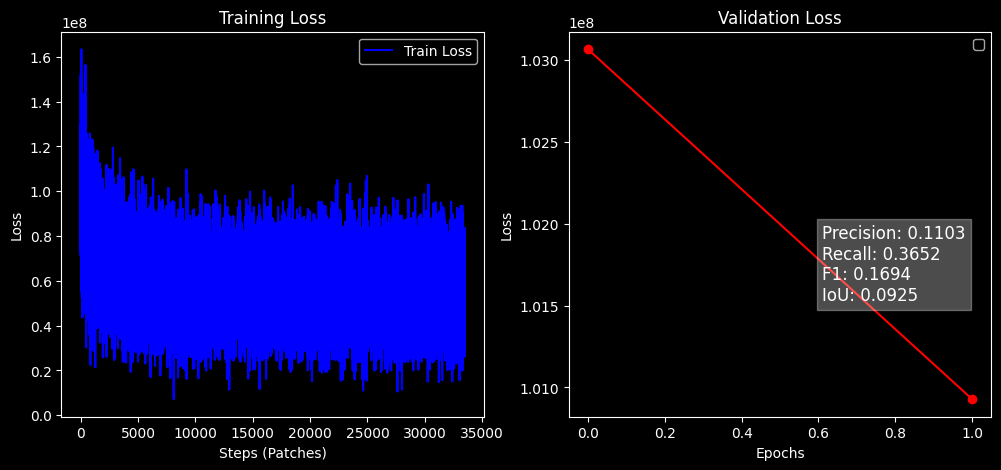

Epoch [2/20]  Train Loss: 58120943.0571  Val Loss: 100927710.4499
Saving best model at epoch 2 with val loss 100927710.4499
Model saved at checkpoints/RoadSegMulde/best_log_density_segmentation_model.pth
Model saved at checkpoints/RoadSegMulde/log_density_segmentation_checkpoint.pth


Training Epoch:   0%|          | 24/16759 [00:18<3:39:14,  1.27it/s]


KeyboardInterrupt: 

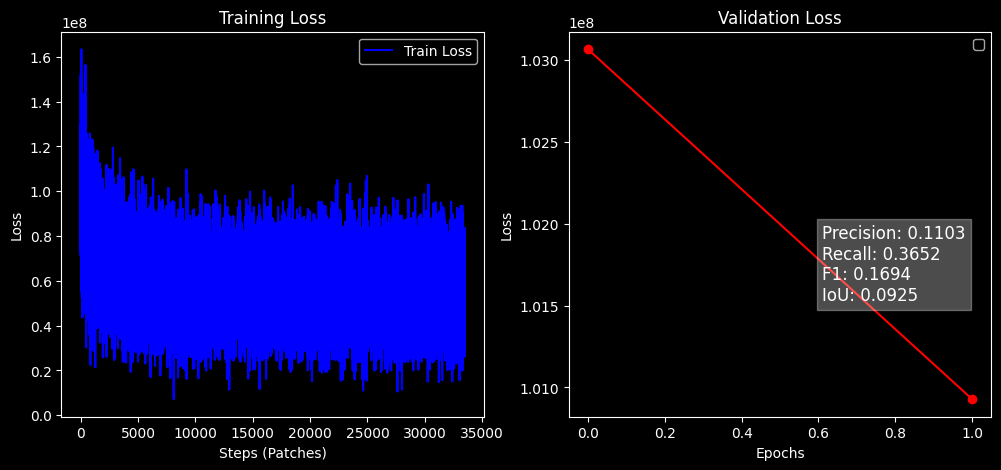

In [4]:
########################################################################
# If you want to switch between training modes, set TRAIN_METHOD to either:
#   "Unsupervised"  (only DSM loss is used)
#   "Hybrid"        (DSM loss + segmentation loss)
########################################################################


# ----------------------------------------------------------------------------
# Modify the function to return the noise that was added as well.
# ----------------------------------------------------------------------------
def add_all_noise_levels_to_features(features, noise_levels):
    """
    Adds multiple noise levels to the extracted ResNet features and also returns the
    added noise and the noise level for each sample.

    Args:
        features (torch.Tensor): Feature tensor from ResNet, shape (B, feature_dim).
        noise_levels (torch.Tensor): 1D tensor containing predefined noise levels.

    Returns:
        features_with_noise_level (torch.Tensor): Tensor of shape (B * L, feature_dim + 1)
            where the additional column contains the noise level.
        noise (torch.Tensor): The noise that was added (shape: (B * L, feature_dim)).
        sigma_expanded (torch.Tensor): The noise level (sigma) corresponding to each sample,
            shape (B * L, 1).
    """
    batch_size, feature_dim = features.shape
    num_levels = len(noise_levels)
    
    # Repeat features for each noise level: shape (B * L, feature_dim)
    repeated_features = features.repeat_interleave(num_levels, dim=0)
    
    # Expand noise levels: shape (B * L, 1)
    sigma_expanded = noise_levels.repeat(batch_size, 1).T.flatten().unsqueeze(1)
    
    # Draw noise from N(0, I) and scale by sigma
    noise = torch.randn_like(repeated_features) * sigma_expanded
    
    # Add noise to features
    noisy_features = repeated_features + noise
    
    # Concatenate the noise level as an extra feature
    features_with_noise_level = torch.cat([noisy_features, sigma_expanded], dim=1)
    
    return features_with_noise_level, noise, sigma_expanded



########################################################################
# Live Plot Helper (Jupyter-Compatible)
########################################################################
class LivePlotter:
    def __init__(self, steps=LIVE_STEPS):
        self.train_steps = []
        self.train_losses = []
        self.val_epochs = []
        self.val_losses = []
        self.precision_list = []
        self.recall_list = []
        self.f1_list = []
        self.iou_list = []
        self.step_count = 0
        self.steps = steps
        # Initialize figure
        self.fig, self.ax = plt.subplots(1, 2, figsize=(12, 5))

    def update_train_plot(self, loss):
        """Update training loss plot every steps"""
        self.step_count += 1
        self.train_steps.append(self.step_count)
        self.train_losses.append(loss)

        if self.step_count % self.steps == 0: 
            clear_output(wait=True)  # Clear previous output
            self.ax[0].clear()
            self.ax[0].plot(self.train_steps, self.train_losses, label="Train Loss", color="blue")
            self.ax[0].set_xlabel("Steps (Patches)")
            self.ax[0].set_ylabel("Loss")
            self.ax[0].set_title("Training Loss")
            self.ax[0].legend()
            
            display(self.fig)  # Show updated plot

    def update_val_plot(self, val_loss=None, precision=None, recall=None, f1=None, iou=None):
        """Update validation loss & metrics plot even when segmentation loss is not available"""
        self.val_epochs.append(len(self.val_epochs))
        
        if val_loss is not None:
            self.val_losses.append(val_loss)

        # Clear previous output for smooth updating
        clear_output(wait=True)

        # Validation loss plot
        self.ax[1].clear()

        # Only plot validation loss if it's available
        if self.val_losses:
            self.ax[1].plot(self.val_epochs, self.val_losses, label="Val Loss", marker="o", color="red")
            self.ax[1].set_xlabel("Epochs")
            self.ax[1].set_ylabel("Loss")
            self.ax[1].set_title("Validation Loss")

            # Remove any previous legend and add a new one
            handles, labels = self.ax[1].get_legend_handles_labels()
            if "Val Loss" in labels:  # Avoid duplicate labels
                labels.remove("Val Loss")
                handles.pop()
            self.ax[1].legend(handles, labels)

        # Only display metrics if they exist
        if precision is not None and recall is not None and f1 is not None and iou is not None:
            text_str = f"Precision: {precision:.4f}\nRecall: {recall:.4f}\nF1: {f1:.4f}\nIoU: {iou:.4f}"
            self.ax[1].text(0.6, 0.5, text_str, transform=self.ax[1].transAxes, fontsize=12,
                            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.3))

        display(self.fig)  # Show updated figure


    def save_plots(self):
        """Save final plots after training"""
        self.fig.savefig("training_validation_plot.png")
        print("Saved Training and Validation Loss Plots")


# Initialize live plotter for Jupyter Notebook
plotter = LivePlotter()
images, targets, _ = next(iter(train_loader))
print(f"Images Shape: {images.shape}, Targets Shape: {targets.shape}")



# ----------------------------------------------------------------------------
# Define a helper segmentation loss function.
# Here we mimic your earlier segmentation loss formulation
# (MSE loss plus a term based on the negative mean prediction).
# You can replace it with cross-entropy, Dice loss, etc.
# ----------------------------------------------------------------------------
# def segmentation_loss(predictions, targets):
#     # predictions: (B, H, W), already passed through a sigmoid
#     targets = targets.float()
#     mse_loss = F.mse_loss(predictions, targets)
#     log_likelihood_loss = -predictions.mean()
#     return mse_loss + log_likelihood_loss

def segmentation_loss(predictions, targets, mse_weight=0.5, bce_weight=0.3, dice_weight=0.2, smooth=1.0):
    """
    Combined loss for segmentation:
    - MSE Loss: Pixel-wise similarity.
    - BCE Loss: Per-pixel classification.
    - Dice Loss: Encourages better overlap with ground truth.
    
    Args:
        predictions (torch.Tensor): Model output after sigmoid (B, H, W).
        targets (torch.Tensor): Ground truth binary masks (B, H, W).
        mse_weight (float): Weight for MSE loss.
        bce_weight (float): Weight for BCE loss.
        dice_weight (float): Weight for Dice loss.
        smooth (float): Smoothing factor to avoid division by zero.
    
    Returns:
        torch.Tensor: Weighted sum of MSE, BCE, and Dice losses.
    """
    targets = targets.float()

    # --- MSE Loss ---
    mse_loss = F.mse_loss(predictions, targets)

    # --- Binary Cross-Entropy (BCE) Loss ---
    bce_loss = F.binary_cross_entropy(predictions, targets)

    # --- Dice Loss ---
    intersection = (predictions * targets).sum(dim=(1, 2))
    dice_loss = 1 - (2.0 * intersection + smooth) / (predictions.sum(dim=(1, 2)) + targets.sum(dim=(1, 2)) + smooth)
    dice_loss = dice_loss.mean()  # Average over batch

    # --- Final Weighted Loss ---
    total_loss = mse_weight * mse_loss + bce_weight * bce_loss + dice_weight * dice_loss

    # Optional Log-Likelihood Regularization (Encourages uncertainty awareness)
    log_likelihood_loss = -predictions.mean()
    total_loss += log_likelihood_loss

    return total_loss

# ----------------------------------------------------------------------------
# Training loop (one epoch)
# ----------------------------------------------------------------------------
def train_epoch():
    global patch_count
    log_density_model.train()
    running_loss = 0.0
    patch_count = 0

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training Epoch")):
        images, targets, _ = batch
        if images is None:
            continue
        images = images.to(DEVICE)
        targets = targets.to(DEVICE).float()
        batch_size = images.shape[0]
        
        # Extract features from images using the pretrained ResNet
        # resnet returns shape (B, feature_dim, 1, 1) so we squeeze twice.
        features = resnet(images).squeeze(-1).squeeze(-1)  # shape: (B, 2048)
        
        # Add noise at all predefined levels.
        # This returns:
        #   - features_with_noise_level: (B * L, feature_dim+1)
        #   - noise: the noise that was added, (B * L, feature_dim)
        #   - sigma_expanded: the noise level per sample, (B * L, 1)
        features_with_noise, noise_added, sigma_expanded = add_all_noise_levels_to_features(features, noise_levels)
        # features_with_noise.requires_grad_(True)
        features_with_noise = features_with_noise.clone().detach().requires_grad_(True)

        # --- DSM (unsupervised) branch ---
        # Call the .score() method which returns both the score prediction and log density.
        # (The ScoreOrLogDensityNetwork is set up so that its score() method accepts a tensor
        #  with concatenated noise-level as the last column.)
        if RETURN_LOG_DENSITY:
            score_pred, log_density_pred = log_density_model.score(features_with_noise, return_log_density=True)
        else:
            score_pred = log_density_model.score(features_with_noise, return_log_density=False)
            log_density_pred = None
        
        # Compute DSM loss only for nonzero noise levels (avoid division by zero)
        nonzero_mask = (sigma_expanded != 0).squeeze()  # Boolean mask
        
        nonzero_mask = (sigma_expanded != 0).squeeze()
        loss_dsm = torch.tensor(0.0, device=DEVICE)
        if nonzero_mask.sum() > 0:
            score_nonzero = score_pred[nonzero_mask]
            noise_nonzero = noise_added[nonzero_mask]
            sigma_nonzero = sigma_expanded[nonzero_mask]
            lambda_factor = sigma_nonzero ** 2
            # Exclude the last dimension (which holds the noise-level)
            # and compare with the scaled noise.
            dsm_term = torch.norm(score_nonzero[:, :-1] + noise_nonzero / (sigma_nonzero ** 2), dim=-1) ** 2
            loss_dsm = (lambda_factor * dsm_term).sum() / batch_size  # Normalize by patches

        
        # --- Segmentation branch ---
        # Use only the "clean" branch (where sigma == 0) to obtain segmentation predictions.
        loss_seg = torch.tensor(0.0, device=DEVICE)
        if RETURN_LOG_DENSITY and log_density_pred is not None:
            clean_mask = (sigma_expanded == 0).squeeze()
            if clean_mask.sum() > 0:
                clean_log_density = log_density_pred[clean_mask]  # shape: (B, WINDOW_SIZE*WINDOW_SIZE)
                # Reshape to (B, WINDOW_SIZE, WINDOW_SIZE) and apply sigmoid to get probabilities.
                seg_pred = torch.sigmoid(clean_log_density).view(-1, WINDOW_SIZE, WINDOW_SIZE)
                loss_seg = segmentation_loss(seg_pred, targets)
        
        # --- Combine losses based on the chosen training mode ---
        if TRAIN_METHOD == "Unsupervised":
            loss = loss_dsm
        elif TRAIN_METHOD == "Hybrid":
            loss = loss_seg + DSM_WEIGHT * loss_dsm
        else:
            # Default to segmentation only if no valid training mode is selected.
            loss = loss_seg
        
        if DEBUG_LOSS_VALUES and (batch_idx + 1) % LIVE_STEPS == 0:
            print(f"Training  - Loss DSM: {loss_dsm.item()} , Weighted: {DSM_WEIGHT * loss_dsm}, Loss Seg: {loss_seg.item()}, Loss Total: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_size
        patch_count += batch_size

        plotter.update_train_plot(loss.item()) # Update the training plot with the current loss value
    
    avg_loss = running_loss / patch_count

    return avg_loss


# ----------------------------------------------------------------------------
# Validation loop (one epoch)
# For hybrid training, we also compute segmentation metrics.
# ----------------------------------------------------------------------------
def validate_epoch():
    log_density_model.eval()
    total_loss = 0.0
    patch_count = 0
    seg_preds_list = []
    seg_targets_list = []
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(val_loader, desc="Validation Epoch")):
            images, targets, _ = batch
            if images is None:
                continue

            images = images.to(DEVICE)
            targets = targets.to(DEVICE).float()
            batch_size = images.shape[0]
        
            features = resnet(images).squeeze(-1).squeeze(-1)

             # Remove `torch.no_grad()` inside the loop for DSM loss computation
            with torch.enable_grad():  # Enable gradient computation for DSM loss
                features_with_noise, noise_added, sigma_expanded = add_all_noise_levels_to_features(features, noise_levels)
                features_with_noise.requires_grad_(True)  # Ensure gradients are tracked

                if RETURN_LOG_DENSITY:
                    score_pred, log_density_pred = log_density_model.score(features_with_noise, return_log_density=True)
                else:
                    score_pred = log_density_model.score(features_with_noise, return_log_density=False)
                    log_density_pred = None

                
                # Compute DSM loss
                nonzero_mask = (sigma_expanded != 0).squeeze()
                loss_dsm = torch.tensor(0.0, device=DEVICE)
                if nonzero_mask.sum() > 0:
                    score_nonzero = score_pred[nonzero_mask]
                    noise_nonzero = noise_added[nonzero_mask]
                    sigma_nonzero = sigma_expanded[nonzero_mask]
                    lambda_factor = sigma_nonzero ** 2
                    dsm_term = torch.norm(score_nonzero[:, :-1] + noise_nonzero / (sigma_nonzero ** 2), dim=-1) ** 2
                    loss_dsm = (lambda_factor * dsm_term).sum() / batch_size  # Normalize by patches

            loss_seg = torch.tensor(0.0, device=DEVICE)
            precision, recall, f1, iou = None, None, None, None
            # Re-enable `torch.no_grad()` for segmentation loss evaluation
            with torch.no_grad():
                loss_seg = torch.tensor(0.0, device=DEVICE)
                if RETURN_LOG_DENSITY and log_density_pred is not None:
                    clean_mask = (sigma_expanded == 0).squeeze()
                    if clean_mask.sum() > 0:
                        clean_log_density = log_density_pred[clean_mask]
                        seg_pred = torch.sigmoid(clean_log_density).view(-1, WINDOW_SIZE, WINDOW_SIZE)
                        loss_seg = segmentation_loss(seg_pred, targets)
                        seg_preds_list.append(seg_pred)
                        seg_targets_list.append(targets)
                        
                clean_mask = (sigma_expanded == 0).squeeze()
                loss_seg = torch.tensor(0.0, device=DEVICE)
                
                    
                if TRAIN_METHOD == "Unsupervised":
                    loss = loss_dsm
                elif TRAIN_METHOD == "Hybrid":
                    loss = loss_seg + DSM_WEIGHT * loss_dsm
                else:
                    loss = loss_seg
                
                total_loss += loss.item() * batch_size
                patch_count += batch_size

            avg_val_loss = total_loss / patch_count  # Normalize by patches

            if TRAIN_METHOD == "Unsupervised":
                loss = loss_dsm
            elif TRAIN_METHOD == "Hybrid":
                loss = loss_seg + DSM_WEIGHT * loss_dsm
            else:
                loss = loss_seg
            
            if DEBUG_LOSS_VALUES and (batch_idx + 1) % LIVE_STEPS == 0:
                print(f"Validation  - Loss DSM: {loss_dsm.item()} , Weighted: {DSM_WEIGHT * loss_dsm}, Loss Seg: {loss_seg.item()}, Loss Total: {loss.item()}")       
            total_loss += loss.item() * batch_size
            patch_count += batch_size
            
    
    avg_val_loss = total_loss / patch_count # Normalize by patches

    
    if TRAIN_METHOD == "Hybrid" and seg_preds_list:
        seg_preds_all = torch.cat(seg_preds_list, dim=0)
        seg_targets_all = torch.cat(seg_targets_list, dim=0)
        precision, recall, f1, iou = calculate_metrics(seg_preds_all, seg_targets_all)
        print(f"Validation Segmentation Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, IoU: {iou:.4f}")
        plotter.update_val_plot(avg_val_loss, precision, recall, f1, iou)
    
    if RETURN_LOG_DENSITY and seg_preds_list:
        seg_preds_all = torch.cat(seg_preds_list, dim=0)
        seg_targets_all = torch.cat(seg_targets_list, dim=0)
        precision, recall, f1, iou = calculate_metrics(seg_preds_all, seg_targets_all)

    plotter.update_val_plot(avg_val_loss, precision, recall, f1, iou)

    return avg_val_loss


# ----------------------------------------------------------------------------
# Main training loop
# ----------------------------------------------------------------------------
best_val_loss = float("inf")
for epoch in range(start_epoch, NUM_EPOCHS):
    train_loss = train_epoch()
    val_loss = validate_epoch()
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")
    
    # Save the model if the validation loss improved.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        print(f"Saving best model at epoch {epoch+1} with val loss {val_loss:.4f}")
        save_model(log_density_model, optimizer, epoch, val_loss, BEST_MODEL_PATH)

    save_model(log_density_model, optimizer, epoch, val_loss, CHECKPOINT_PATH)



In [ ]:
28198060.0 / 128 /128 / 32 / 32

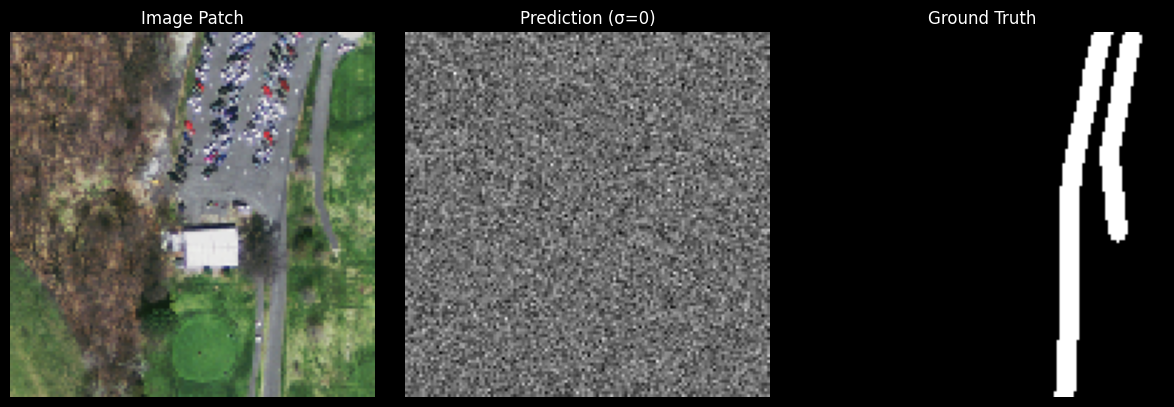

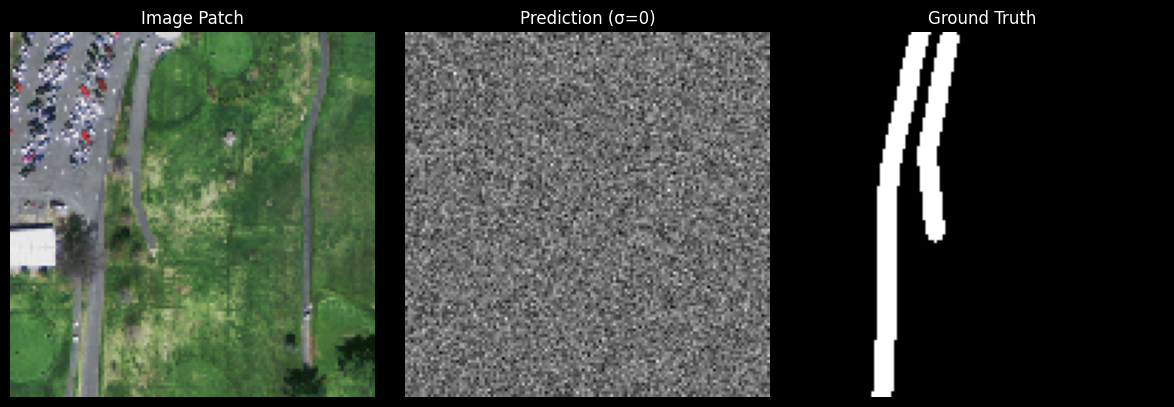

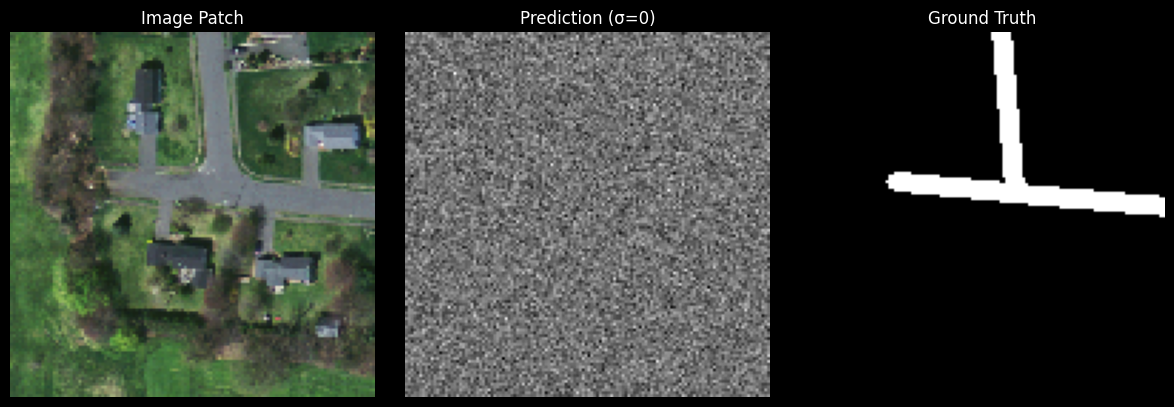

In [7]:
import matplotlib.pyplot as plt
import torch

def plot_zero_noise_predictions(
    model,         # ScoreOrLogDensityNetwork
    feature_net,   # e.g., ResNet feature extractor
    loader,        # A DataLoader (train_loader, val_loader or test_loader)
    device, 
    window_size=128,
    n_samples=3
):
    """
    Show n_samples predictions at zero noise level along with the patch & ground truth.
    """

    model.eval()                # Switch to eval mode
    feature_net.eval()          # Typically kept in eval mode too

    # Grab one batch of data
    images, targets, _ = next(iter(loader))

    # Move to device
    images, targets = images.to(device), targets.to(device)
    
    # Extract features via the pretrained ResNet (or any feature net)
    with torch.no_grad():
        feats = feature_net(images).squeeze(-1).squeeze(-1)  # (B, 2048) for ResNet-50

    # Construct input for zero-noise level:
    #   concatenating feats with a 0-column for noise level
    #   shape -> (B, 2048 + 1)
    zero_noise = torch.zeros(feats.size(0), 1, device=device)
    feats_zero_noise = torch.cat([feats, zero_noise], dim=1)

    # Forward pass through the ScoreOrLogDensityNetwork
    # with torch.no_grad():
    # If your network returns (score, log_density) when return_log_density=True:
    _, log_density_pred = model.score(feats_zero_noise, return_log_density=True)
    # Reshape to (B, H, W), apply sigmoid to get probabilities
    seg_pred = torch.sigmoid(log_density_pred).view(-1, window_size, window_size)

    # Plot up to n_samples results
    for i in range(min(n_samples, images.size(0))):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        # Show the patch (RGB)
        axes[0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
        axes[0].set_title("Image Patch")
        axes[0].axis("off")

        # Show predicted mask (grayscale)
        axes[1].imshow(seg_pred[i].cpu().detach().numpy(), cmap="gray")
        axes[1].set_title("Prediction (σ=0)")
        axes[1].axis("off")

        # Show ground truth (grayscale)
        axes[2].imshow(targets[i].cpu().numpy(), cmap="gray")
        axes[2].set_title("Ground Truth")
        axes[2].axis("off")

        plt.tight_layout()
        plt.show()


############################################
# Example usage in your training script:
############################################

# ...
# Assume you already have:
#   log_density_model        # ScoreOrLogDensityNetwork
#   resnet                  # feature_net, e.g. ResNet-50
#   test_loader             # or val_loader
#   DEVICE

plot_zero_noise_predictions(
    model=log_density_model,
    feature_net=resnet,
    loader=val_loader,#test_loader,      # or val_loader
    device=DEVICE,
    window_size=128,
    n_samples=3
)

In [ ]:

# # ----------------------------------------------------------------------------
# # Optionally, define a test function to evaluate the model on the test set.
# # ----------------------------------------------------------------------------
# def test_model():
#     log_density_model.eval()
#     seg_preds_list = []
#     seg_targets_list = []
    
#     with torch.no_grad():
#         for batch in tqdm(test_loader, desc="Testing"):
#             images, targets, _ = batch
#             images = images.to(DEVICE)
#             targets = targets.to(DEVICE).float()
#             if images is None:
#                 continue
#             features = resnet(images).squeeze(-1).squeeze(-1)
#             features_with_noise, noise_added, sigma_expanded = add_all_noise_levels_to_features(features, noise_levels)

#             score_pred, log_density_pred = log_density_model.score(features_with_noise, return_log_density=RETURN_LOG_DENSITY)
            
#             clean_mask = (sigma_expanded == 0).squeeze()
#             if clean_mask.sum() > 0:
#                 clean_log_density = log_density_pred[clean_mask]
#                 seg_pred = torch.sigmoid(clean_log_density).view(-1, WINDOW_SIZE, WINDOW_SIZE)
#                 seg_preds_list.append(seg_pred)
#                 seg_targets_list.append(targets)
    
#     if seg_preds_list:
#         seg_preds_all = torch.cat(seg_preds_list, dim=0)
#         seg_targets_all = torch.cat(seg_targets_list, dim=0)
#         precision, recall, f1, iou = calculate_metrics(seg_preds_all, seg_targets_all)
#         print(f"Test Metrics - Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, IoU: {iou:.4f}")

# # Run testing after training
# test_model()


In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(image, prediction, ground_truth):
    """Plots the original image, predicted segmentation mask, and ground truth."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(image.permute(1, 2, 0).cpu().numpy())  # Original image
    axes[0].set_title("Original Image")
    
    axes[1].imshow(prediction.cpu().numpy(), cmap="gray")  # Predicted segmentation mask
    axes[1].set_title("Predicted Mask")
    
    axes[2].imshow(ground_truth.cpu().numpy(), cmap="gray")  # Ground truth mask
    axes[2].set_title("Ground Truth")

    plt.show()


In [ ]:
def plot_patches_and_distribution_with_counts(sat_patches, map_patches, metadata, n_patches=3):
    """
    Efficiently plots randomly selected satellite patches, road masks, and road pixel distributions.
    
    Args:
        sat_patches (Tensor): Batch of satellite image patches.
        map_patches (Tensor): Batch of road mask patches.
        metadata (List[Tuple[int, int, int]]): Metadata with (image_idx, y, x).
        n_patches (int): Number of patches to visualize.
    """
    n_patches = min(n_patches, sat_patches.shape[0])  # Ensure we do not exceed available patches

    # Randomly select `n_patches` indices from the batch
    selected_indices = random.sample(range(sat_patches.shape[0]), n_patches)

    fig, axes = plt.subplots(n_patches, 3, figsize=(15, 5 * n_patches))

    # Ensure axes is always iterable
    if n_patches == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, idx in enumerate(selected_indices):
        sat_patch = sat_patches[idx]
        map_patch = map_patches[idx]

        # Convert tensors to numpy
        if isinstance(sat_patch, torch.Tensor):
            sat_patch = sat_patch.cpu().numpy().transpose(1, 2, 0)  # Convert to HxWxC
        if isinstance(map_patch, torch.Tensor):
            map_patch = map_patch.cpu().numpy()

        # Extract metadata (fix KeyError)
        image_idx, y, x = metadata[idx]  

        # Plot Satellite Patch
        axes[i][0].imshow(sat_patch)
        axes[i][0].set_title(f"Satellite Patch {i+1}\nImage Index: {image_idx}, Coords: ({y}, {x})")
        axes[i][0].axis('off')

        # Plot Map Patch
        axes[i][1].imshow(map_patch, cmap='gray')
        axes[i][1].set_title(f"Map Patch {i+1}")
        axes[i][1].axis('off')

        # Plot Distribution of Road Pixels
        road_pixel_count = np.sum(map_patch)
        non_road_pixel_count = map_patch.size - road_pixel_count
        labels = ['Non-Road', 'Road']
        sizes = [non_road_pixel_count, road_pixel_count]

        axes[i][2].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['gray', 'blue'])
        axes[i][2].set_title(f"Road Pixel Distribution (Patch {i+1})")

    plt.show()


# Count total batches in the dataset
total_batches = len(train_loader)

print(f"Total Batches in Dataset: {total_batches}\n")

# Iterate through the DataLoader and print batch sizes
for batch_idx, (sat_patches, map_patches, metadata) in enumerate(train_loader):
    if sat_patches is None or map_patches is None:
        print(f"Batch {batch_idx+1}: Skipped (Empty Batch)")
        continue  # Skip empty batches

    # Print batch info
    print(f"\nBatch {batch_idx+1}/{total_batches}:")
    print(f"  Requested Batch Size: {BATCH_SIZE}")
    print(f"  Actual Batch Size: {sat_patches.shape[0]}")  # The number of patches in this batch
    print(f"  Patch Shape: {sat_patches.shape}")  # (batch_size, channels, height, width)

    if batch_idx >= 3:  # Stop printing after a few batches to avoid excessive output
        break


# --- Efficiently Load ONE Batch ---
try:
    batch = next(iter(train_loader))  # Load one batch
    sat_patches, map_patches, metadata = batch

    if sat_patches is not None and len(sat_patches) > 0:
        plot_patches_and_distribution_with_counts(sat_patches, map_patches, metadata, n_patches=3)  # Show 3 patches
    else:
        print("No valid patches found in the batch.")

except StopIteration:
    print("No data available in train_loader.")


noise_levels

### **Scenario: Learning the Distribution of Roads**
You are **learning the distribution of roads** when you use **DSM loss** to train the MULDE model. This occurs when:

1. **TRAIN_METHOD = "Unsupervised"**  
   - Only the DSM loss is used.  
   - The model is trained to approximate the **score function** (i.e., the gradient of the log-density of road features).  
   - No segmentation labels are used in training.  

2. **TRAIN_METHOD = "Hybrid"** (Partial Distribution Learning)  
   - DSM loss is still computed, but segmentation loss is also included.  
   - The model learns **both** the distribution of road pixels **and** a direct segmentation mapping.

3. **RETURN_LOG_DENSITY = True**  
   - The model is explicitly predicting log-density values.  
   - The log-density represents how likely a feature (from ResNet) belongs to the distribution of road pixels.  

---

### **Why DSM Loss Helps in Learning the Distribution**
- DSM loss trains the model to estimate **score functions** of the log-probability density function (log-pdf) of the road dataset.
- When the model learns to approximate **score(x) ≈ ∇ log p(x)**, it effectively captures the probability density of roads.
- This means the model **learns the underlying data distribution** rather than a direct classification of pixels.

---

### **Table: When Are You Learning the Road Distribution?**
| **Scenario**                        | **TRAIN_METHOD** | **RETURN_LOG_DENSITY** | **Are You Learning the Road Distribution?** | **Explanation** |
|--------------------------------------|------------------|------------------------|----------------------------------------------|----------------|
| **Case 1: Pure Distribution Learning** | `"Unsupervised"` | `True`                 | ✅ **Yes (Best Setting)** | The model learns the DSM loss and predicts log-density values. This directly models the road distribution. |
| **Case 2: Distribution Learning + Segmentation** | `"Hybrid"`       | `True`                 | ✅ **Partial** | The model learns both the distribution and segmentation. DSM loss still captures road distribution. |
| **Case 3: Learning Score Function (But No Log-Density Output)** | `"Unsupervised"` | `False`                | ✅ **Yes, but Indirectly** | The model still learns DSM loss, but log-density is not explicitly predicted. You can approximate it using score norms. |
| **Case 4: Hybrid Without Log-Density Output** | `"Hybrid"`       | `False`                | ❌ **Not Fully** | The DSM loss still affects training, but without log-density output, the model is biased more toward segmentation. |
| **Case 5: Pure Segmentation** | `"Other"` (Segmentation only) | `True` or `False` | ❌ **No** | The model does not learn the road distribution, only pixel classification. |

---

### **Best Setting for Learning Road Distribution**
🔹 **Use:**  
```python
TRAIN_METHOD = "Unsupervised"
RETURN_LOG_DENSITY = True
```
🔹 **Effect:**  
- The model learns the probability distribution of road features.
- No segmentation labels are used.
- The output log-density can be used for **road anomaly detection**, density estimation, or further probabilistic modeling.

If you also want segmentation while still learning the road distribution, use:
```python
TRAIN_METHOD = "Hybrid"
RETURN_LOG_DENSITY = True
```
This will ensure that DSM loss is present, **but segmentation loss is also included**.

 **If your primary goal is to learn the road distribution, stick to `Unsupervised` mode with `RETURN_LOG_DENSITY=True`.** 